In [1]:
from notepad import WaterStorage, Heatpump
from pyrecoy.forecasts import Mipf
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import cufflinks
cufflinks.go_offline()
from numpy.polynomial import Polynomial
import numpy as np

In [3]:
mipf = Mipf(
    start = '2018-11-01',
    end = '2018-11-01', 
    tidy=True, 
    include_nextQ=False,
    folder_path=r"C:\Users\Shahla Huseynova\Recoy\Recoy - Documents\03 - Libraries\12 - Data Management\Forecast Data"
).data
# mipf.columns
price_data = mipf[['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos']]
# price_data.index = price_data.index.tz_convert('Europe/Amsterdam')
price_data = price_data.resample('15T').mean()
price_data

DAM     POS     NEG     ForeNeg     ForePos
datetime                                                                
2018-11-01 00:00:00+01:00  44.90   46.39   46.39   53.603333   44.623333
2018-11-01 00:15:00+01:00  44.90   43.08   43.08   68.962000   63.177333
2018-11-01 00:30:00+01:00  44.90   43.13   43.13   55.415333   57.922667
2018-11-01 00:45:00+01:00  44.90   46.29   46.29   57.633333   54.712667
2018-11-01 01:00:00+01:00  42.46   32.03   32.03   37.354000   35.400000
...                          ...     ...     ...         ...         ...
2018-11-01 22:45:00+01:00  50.70   54.02   54.02   71.520667   65.263333
2018-11-01 23:00:00+01:00  50.70  202.89  202.89  143.089333  144.426000
2018-11-01 23:15:00+01:00  50.70   85.70   85.70  101.676000   97.244000
2018-11-01 23:30:00+01:00  50.70   38.03   38.03   50.560000   45.735333
2018-11-01 23:45:00+01:00  50.70   30.53   30.53   45.584667   40.736000

[96 rows x 5 columns]

In [4]:
data = pd.read_excel('Demand_Data_Smurfit_Preprocessed.xlsx', sheet_name='nov2018', index_col=0)
start, end = '2018-11-01 00:00:00', '2018-11-01 12:00:00'
df = data[start:end]
df.index = df.index.tz_localize('Europe/Amsterdam')
df = df.resample('15T').mean()
df=df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis=1)

df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)  
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0

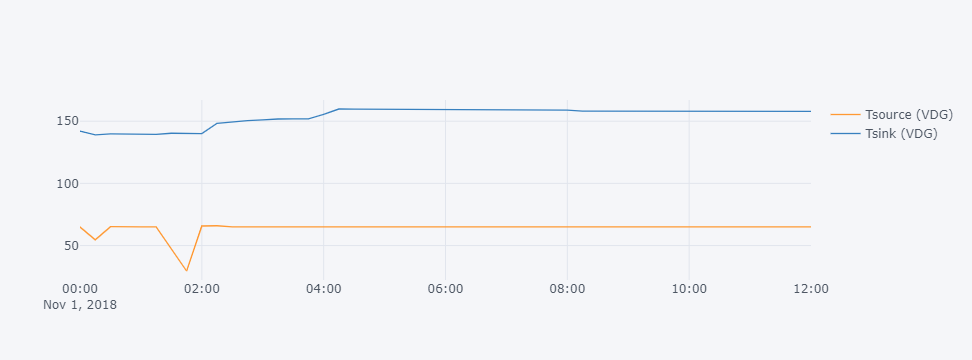

In [37]:
df[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

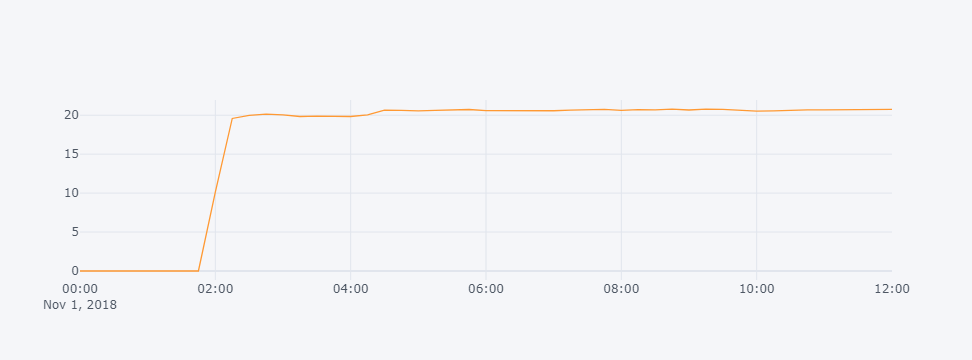

In [38]:
df['MW (VDG)'].iplot()

In [6]:
waterstorage = WaterStorage(
    name='MyStorage',
    max_power=10,
    min_power=-10,
    roundtrip_eff=0.90,
    capacity_per_volume = 50 * 1e-3,
    volume = 1000,
    lifetime = 25,
    temperature = 368, #K
    min_storagelevel = 5,
    # max_storagelevel = 50
    
)
waterstorage.set_freq('15T')
waterstorage.set_storagelevel(15)
waterstorage.storagelevel

15

In [7]:
Tsink = 140  #Celcius
Tsource = 60
Tref = 0
hp_capacity = 31 #MW
process_demand_MW = 25 #MW
Cp = 4190  #J/kgK
MWtoJs = 1000_000
efficiency = 0.9
Tstorage = 95

print('process demand', process_demand_MW)
# hp_capacity vs hp_load?

process demand 25


In [8]:
waterstorage.max_storage_capacity

50.0

In [9]:
print('process_demand_MW', process_demand_MW)
print('hp_capacity', hp_capacity)

process_demand_MW 25
hp_capacity 31


In [10]:
def hp_mass_flow (hp_capacity, Tsink, Tref, Cp):
    return hp_capacity * MWtoJs /(Cp*(Tsink - Tref)) #kg/s

def process_mass_flow (process_demand_MW, Tsink, Tref, Cp):
    return process_demand_MW * MWtoJs /(Cp*(Tsink - Tref)) 

def cop_curve(Tsink, Tsource):
    c0 = Tsink / (Tsink - Tsource)  
    return Polynomial([c0])

# charge_mass_flow = hp_mass_flow (hp_capacity, Tsink, Tref, Cp) - process_mass_flow (process_demand_MW, Tsink, Tref, Cp)  #kg/s

# def energy_to_storage (charge_mass_flow, Cp, Tsink, Tref):
#     return (charge_mass_flow * Cp * (Tsink - Tref)) / MWtoJs

def energy_to_storage(hp_capacity, process_demand_MW):
    return hp_capacity - process_demand_MW  #MW


# discharged_heat = energy_to_storage(hp_capacity, process_demand_MW) #MW

# def charged_heat (charge_mass_flow, Cp, Tsink, Tref):
#     return (charge_mass_flow * Cp * (Tsink - Tref)) / MW_to_J_per_s

# discharged_heat = charged_heat(charge_mass_flow, Cp, Tsink, Tref)  #MW

def discharge_mass_flow (discharged_heat, Cp, Tstorage, Tref):
    return discharged_heat*MWtoJs/(Cp*(Tstorage - Tref))

def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
    return ((Tstorage * discharge_mass_flow + Tsource * process_mass_flow)
 / (discharge_mass_flow + process_mass_flow))


# charged_heat can be also defined as hp_capacity-process_demand_MW

In [11]:
energy_to_storage(hp_capacity, process_demand_MW)

6

In [12]:
# heatpump = Heatpump("heatpump1", 50, cop_curve, 10)
# heatpump.set_heat_output(50, Tsource=333, Tsink=413)
cop_curve(140, 60)

heatpump = Heatpump(
    name='Heatpump',
    max_th_power=40,
    min_th_power=5,
    cop_curve=cop_curve
)

heatpump.__dict__



{'name': 'Heatpump',
 'max_th_power': 40,
 'min_th_power': 5,
 'cop_curve': <function __main__.cop_curve(Tsink, Tsource)>}

In [13]:
heatpump.get_cop(50, Tsource=333, Tsink=413)


5.1625

In [14]:
heatpump.set_heat_output(20, Tsource=333, Tsink=41+372)


(-3.8740920096852305, 20)

In [15]:
for col in price_data.columns:
    df[col] = price_data[col]
df.head(10)
# iki dataframeni birlesdirdik burda

Tsource (VDG)  Tsink (VDG)   MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109   0.000000   
2018-11-01 00:15:00+01:00      54.578777   138.960493   0.000000   
2018-11-01 00:30:00+01:00      65.166672   139.885329   0.000000   
2018-11-01 00:45:00+01:00      65.358078   139.731901   0.000000   
2018-11-01 01:00:00+01:00      64.947536   139.577871   0.000000   
2018-11-01 01:15:00+01:00      65.073433   139.423357   0.000000   
2018-11-01 01:30:00+01:00      47.711559   140.328730   0.000000   
2018-11-01 01:45:00+01:00      29.525829   140.298902   0.000000   
2018-11-01 02:00:00+01:00      65.715569   139.991650  10.139587   
2018-11-01 02:15:00+01:00      65.929909   148.342325  19.585104   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814  0.000000  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964  0.000000  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426  0.000000  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612  0.000000  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335  0.000000  42.46  32.03   
2018-11-01 01:15:00+01:00      19.903652   149.186865  0.000000  42.46  32.03   
2018-11-01 01:30:00+01:00      19.574467   147.800016  0.000000  42.46  34.48   
2018-11-01 01:45:00+01:00      17.065464   147.906886  0.000000  42.46  32.07   
2018-11-01 02:00:00+01:00      49.339708   149.603741  3.333301  44.00  40.66   
2018-11-01 02:15:00+01:00      61.721718   155.887905  6.455359  44.00  46.04   

                             NEG    ForeNeg    ForePos  
2018-11-01 00:00:00+01:00  46.39  53.603333  44.623333  
2018-11-01 00:15:00+01:00  43.08  68.962000  63.177333  
2018-11-01 00:30:00+01:00  43.13  55.415333  57.922667  
2018-11-01 00:45:00+01:00  46.29  57.633333  54.712667  
2018-11-01 01:00:00+01:00  32.03  37.354000  35.400000  
2018-11-01 01:15:00+01:00  32.03  35.934000  31.469333  
2018-11-01 01:30:00+01:00  34.48  37.640000  35.276000  
2018-11-01 01:45:00+01:00  32.07  31.026667  28.963333  
2018-11-01 02:00:00+01:00  40.66  40.547333  38.702000  
2018-11-01 02:15:00+01:00  46.04  44.696000  42.961333

In [16]:
for i in df.index:
    df.loc[i, 'hp_mass'] = hp_mass_flow(hp_capacity, df.loc[i, 'Tsink (VDG)'], Tref, Cp)
    df.loc[i, 'process_mass'] = process_mass_flow(df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)'],Tref, Cp)
    df.loc[i, 'COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
    df.loc[i, 'charge_mass'] = df.loc[i, 'hp_mass'] - df.loc[i, 'process_mass']
    


In [39]:
# df.index = df.index.tz_localize('Europe/Amsterdam')
for i in df.index:
#     logic that applies IF NO STORAGE, BASELINE CASE

 
    hp_load = df.loc[i, 'MW (VDG)']
    old_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
    hp_consumption_old = hp_load/ old_COP
    # df.loc[i,'hp_consumption_old'] = hp_load/ old_COP
        
    if df.loc[i, 'ForeNeg'] <  50:
        hp_load = heatpump.max_th_power
        energy_2_storage = hp_load - df.loc[i, 'MW (VDG)']
        waterstorage.charge(energy_2_storage)
        df.loc[i, 'charged_heat'] = waterstorage.charge(energy_2_storage)
        charge_mass = hp_mass_flow (hp_capacity,  df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp) - process_mass_flow (df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp)
        df.loc[i, 'new_cl'] = waterstorage.storagelevel
        new_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
        df.loc[i,'hp_consumption_new'] = hp_load/ new_COP
    elif price_data.loc[i,'ForePos'] > 50:
        # hp_load = heatpump.set_heat_output(df.loc[i, 'MW (VDG)'], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)[1]
        energy_from_storage = energy_to_storage(hp_capacity ,df.loc[i, 'MW (VDG)'])
        waterstorage.discharge(energy_from_storage)
        df.loc[i, 'discharged_heat'] =   waterstorage.discharge(energy_from_storage)
        df.loc[i, 'new_cl'] = waterstorage.storagelevel
        discharge_mass = discharge_mass_flow(df.loc[i, 'discharged_heat'], Cp, Tstorage, Tref)
        df.loc[i, 'discharge_mass'] = discharge_mass
        process_mass = process_mass_flow (df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp)
        df.loc[i, 'Tsource_new'] = Tsource_calculation(Tstorage, df.loc[i, 'discharge_mass'], df.loc[i, 'Tsource (VDG)'], process_mass)
        heat_output = heatpump.set_heat_output(df.loc[i, 'MW (VDG)'], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
        df.loc[i,'hp_consumption_new'] = heat_output[0]
        df.loc[i, 'new_COP'] = heatpump.get_cop(heat_output[1], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
        # df.loc[i,'hp_consumption_new'] = hp_load/ new_COP
        # new_COP = cop_curve (df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
    else:
        hp_load = df.loc[i, 'MW (VDG)']
        df.loc[i, 'old_COP'] = old_COP
        df.loc[i,'hp_consumption_old'] = hp_consumption_old

C:\Users\SHAHLA~1\AppData\Local\Temp/ipykernel_26096/3971255130.py:31: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Shahla Huseynova\python\Encore\Simulations\notepad.py:319: UserWarning:

Chosen heat output is out of range [5 - 40]. Heat output is being limited to the closest boundary.



In [40]:
# for i in df.index:
#     if df.loc[i, 'ForePos'] < 50:
#         hp_load = heatpump.max_th_power
#         old_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
#         df.loc[i,'hp_consumption_old'] = hp_load/ (old_COP * df.loc[i, 'POS'])
#         # df.loc[i,'hp_consumption_new'] = hp_load/df.loc[i,'new_COP'] * df.loc[i, 'POS']

#     elif price_data.loc[i,'ForePos'] > 50:
#         hp_load = heatpump.set_heat_output(df.loc[i, 'MW (VDG)'], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)[1]
#         new_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
#         df.loc[i, 'hp_consumption'] = hp_load/ (new_COP *  df.loc[i, 'POS'] )

# df[:20]

In [41]:
df['hp_consumption_old']

2018-11-01 00:00:00+01:00    0.000000
2018-11-01 00:15:00+01:00    0.000000
2018-11-01 00:30:00+01:00    0.000000
2018-11-01 00:45:00+01:00    0.000000
2018-11-01 01:00:00+01:00    0.000000
2018-11-01 01:15:00+01:00    0.000000
2018-11-01 01:30:00+01:00    0.000000
2018-11-01 01:45:00+01:00    0.000000
2018-11-01 02:00:00+01:00    1.823593
2018-11-01 02:15:00+01:00    3.830747
2018-11-01 02:30:00+01:00    4.001079
2018-11-01 02:45:00+01:00    4.064893
2018-11-01 03:00:00+01:00    4.068391
2018-11-01 03:15:00+01:00    4.052671
2018-11-01 03:30:00+01:00    4.061479
2018-11-01 03:45:00+01:00    4.067838
2018-11-01 04:00:00+01:00    4.188972
2018-11-01 04:15:00+01:00    4.382026
2018-11-01 04:30:00+01:00    4.524195
2018-11-01 04:45:00+01:00    4.507751
2018-11-01 05:00:00+01:00    4.498205
2018-11-01 05:15:00+01:00    4.504487
2018-11-01 05:30:00+01:00    4.516361
2018-11-01 05:45:00+01:00    4.535025
2018-11-01 06:00:00+01:00         NaN
2018-11-01 06:15:00+01:00    4.502226
2018-11-01 0

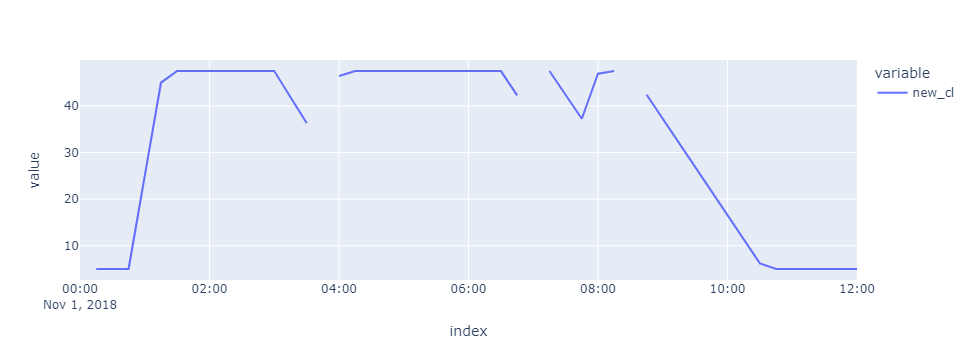

In [42]:
import plotly.express as px

fig = px.line(df['new_cl'])
fig.show()

In [21]:
# df.index = df.index.tz_localize('Europe/Amsterdam')

In [22]:
# df.head()

In [34]:
for col in price_data.columns:
    df[col] = price_data[col]
for cons in ['old', 'new']:
    df['nomination_MWh'] = df['MW (VDG)']#MWTO mWH
    df[f'imbalance_MWh_{cons}'] = df['nomination_MWh'] - df[f'hp_consumption_{cons}']
    df['day-ahead costs'] = df['nomination_MWh'] * df['DAM'] 

    is_pos = df[f'imbalance_MWh_{cons}'] > 0
    df.loc[is_pos, f'imbalance costs_{cons}'] = -df.loc[is_pos, f'imbalance_MWh_{cons}'] * df['POS'] 

    is_neg = df[f'imbalance_MWh_{cons}'] < 0
    df.loc[is_neg, f'imbalance costs_{cons}'] = -df.loc[is_neg, f'imbalance_MWh_{cons}'] * df['NEG'] 

    df[f'total cost_{cons}'] = df['day-ahead costs'] + df[f'imbalance costs_{cons}']
    # df[f'cumulative_{cons}'] =  df[f'total cost_{cons}'].cumsum()

In [35]:
df.head(10)

Tsource (VDG)  Tsink (VDG)   MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109   0.000000   
2018-11-01 00:15:00+01:00      54.578777   138.960493   0.000000   
2018-11-01 00:30:00+01:00      65.166672   139.885329   0.000000   
2018-11-01 00:45:00+01:00      65.358078   139.731901   0.000000   
2018-11-01 01:00:00+01:00      64.947536   139.577871   0.000000   
2018-11-01 01:15:00+01:00      65.073433   139.423357   0.000000   
2018-11-01 01:30:00+01:00      47.711559   140.328730   0.000000   
2018-11-01 01:45:00+01:00      29.525829   140.298902   0.000000   
2018-11-01 02:00:00+01:00      65.715569   139.991650  10.139587   
2018-11-01 02:15:00+01:00      65.929909   148.342325  19.585104   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814  0.000000  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964  0.000000  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426  0.000000  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612  0.000000  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335  0.000000  42.46  32.03   
2018-11-01 01:15:00+01:00      19.903652   149.186865  0.000000  42.46  32.03   
2018-11-01 01:30:00+01:00      19.574467   147.800016  0.000000  42.46  34.48   
2018-11-01 01:45:00+01:00      17.065464   147.906886  0.000000  42.46  32.07   
2018-11-01 02:00:00+01:00      49.339708   149.603741  3.333301  44.00  40.66   
2018-11-01 02:15:00+01:00      61.721718   155.887905  6.455359  44.00  46.04   

                             NEG    ForeNeg  ...  nomination_MWh  \
2018-11-01 00:00:00+01:00  46.39  53.603333  ...        0.000000   
2018-11-01 00:15:00+01:00  43.08  68.962000  ...        0.000000   
2018-11-01 00:30:00+01:00  43.13  55.415333  ...        0.000000   
2018-11-01 00:45:00+01:00  46.29  57.633333  ...        0.000000   
2018-11-01 01:00:00+01:00  32.03  37.354000  ...        0.000000   
2018-11-01 01:15:00+01:00  32.03  35.934000  ...        0.000000   
2018-11-01 01:30:00+01:00  34.48  37.640000  ...        0.000000   
2018-11-01 01:45:00+01:00  32.07  31.026667  ...        0.000000   
2018-11-01 02:00:00+01:00  40.66  40.547333  ...       10.139587   
2018-11-01 02:15:00+01:00  46.04  44.696000  ...       19.585104   

                           imbalance_MWh_old  day-ahead costs  \
2018-11-01 00:00:00+01:00           0.000000         0.000000   
2018-11-01 00:15:00+01:00           0.000000         0.000000   
2018-11-01 00:30:00+01:00           0.000000         0.000000   
2018-11-01 00:45:00+01:00           0.000000         0.000000   
2018-11-01 01:00:00+01:00           0.000000         0.000000   
2018-11-01 01:15:00+01:00           0.000000         0.000000   
2018-11-01 01:30:00+01:00           0.000000         0.000000   
2018-11-01 01:45:00+01:00           0.000000         0.000000   
2018-11-01 02:00:00+01:00           8.315994       446.141846   
2018-11-01 02:15:00+01:00          15.754358       861.744591   

                          imbalance costs_old  total cost_old  cumulative_old  \
2018-11-01 00:00:00+01:00                 NaN             NaN             NaN   
2018-11-01 00:15:00+01:00                 NaN             NaN             NaN   
2018-11-01 00:30:00+01:00                 NaN             NaN             NaN   
2018-11-01 00:45:00+01:00                 NaN             NaN             NaN   
2018-11-01 01:00:00+01:00                 NaN             NaN             NaN   
2018-11-01 01:15:00+01:00                 NaN             NaN             NaN   
2018-11-01 01:30:00+01:00                 NaN             NaN             NaN   
2018-11-01 01:45:00+01:00                 NaN             NaN             NaN   
2018-11-01 02:00:00+01:00         -338.128319      108.013527      108.013527   
2018-11-01 02:15:00+01:00         -725.330620      136.413971      244.427498   

                           im

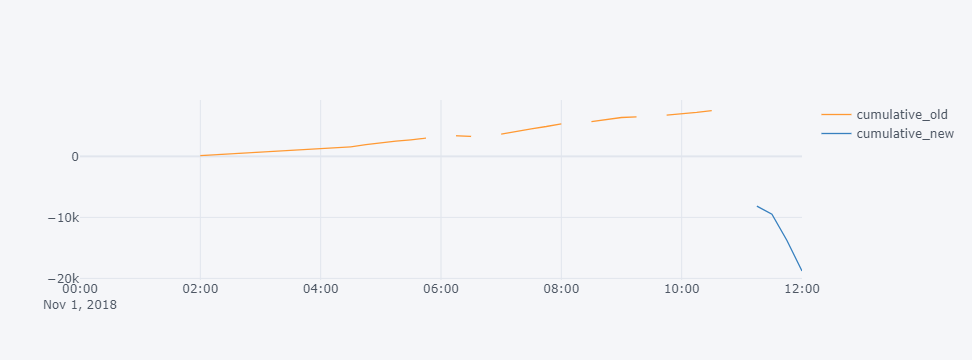

In [36]:
# df[['cumulative_old', 'cumulative_new']].iplot()

In [26]:
print(df['total cost_old'].sum())
print(df['total cost_new'].sum())

7763.909915061883
-18786.900249434475


In [27]:
# discharged_heat = energy_to_storage(hp_capacity,19.585104)

# print(discharged_heat)

# discharge_mass = discharge_mass_flow(discharged_heat, Cp, 140+273, Tref+273)

# print(discharge_mass)

In [28]:
# rng = pd.date_range('2018-11-01 00:00:00', end='2018-11-01 12:00:00', freq='15T' )

# price_data = pd.DataFrame(np.random.randint(30, 110, size=(len(rng))), 
#                   columns=['ForeNeg'], 
#                   index=rng)

# price_data['ForePos'] = np.random.randint(20, 50, size=(len(rng)))

# price_data.head()

In [29]:
# def test_heatpump_and_waterstorage_system(Tsink, Tsource, process_demand_MW, e_price):
#     """
#     1. Follow a certain logic based on given price:
#         - If price is low --> Heatpump at full power, and charge the heatbuffer
#         - If price is high --> Discharge the heat buffer, and increase Tsource, which will increase COP
#     2. Above logic should adhere to a couple of constraints:
#         - Storage levels
#         - Capacity of the heat pump 
#         - Process demand
#         - ....
#     3. This function should contain: 
#         - Heat pump 
#         - Water storage
#         - Interactions / logic between them
#     4. Output of the function:
#         - Power of the heatpump (MWe)
#         - "New" water storage level
#         - (optional) Thermal output of the heatpump
#         - (optional) In/outflow from the storage
#     """
    
#     if e_price < 50:
#         hp_load = heatpump.max_th_power
#         energy_to_storage = hp_load - process_demand_MW
#         waterstorage.charge(energy_to_storage)
#         new_cl = waterstorage.storagelevel
#     if e_price > 100:
#         energy_from_storage = discharged_heat
#         waterstorage.discharge(energy_from_storage)
#         new_cl = waterstorage.storagelevel
        
#         def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
#             return ((Tstorage * discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + Tsource * process_mass_flow(process_demand_MW, Tsink, Tref, Cp))
#                     / (discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + process_mass_flow(process_demand_MW, Tsink, Tref, Cp)))
#         new_COP = cop_curve (Tsink, Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow))
#         hp_load = heatpump.set_heat_output(process_demand_MW, Tsink, Tsource) #bu da hemcinin set load assetin funksiyasidir, 
#         #heatpump da overwrite edilib. men evezinde yazdim ki set_heat_output
#         #sen gor hansi funksiya sene lazimdir.

#     return hp_load, new_cl

In [30]:
# for i in df.index:
#     df.loc[i, 'hp_mass'] = hp_mass_flow(hp_capacity, df.loc[i, 'Tsink (VDG)'], Tref, Cp)
#     df.loc[i, 'process_mass'] = process_mass_flow(df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)'],Tref, Cp)
#     df.loc[i, 'COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
#     df.loc[i, 'charge_mass'] = df.loc[i, 'hp_mass'] - df.loc[i, 'process_mass']
#     df.loc[i, 'charged_heat'] = charged_heat(df.loc[i, 'charge_mass'], Cp, df.loc[i, 'Tsink (VDG)']+273, Tref + 273)
#     df.loc[i, 'discharged_heat'] = charged_heat(df.loc[i, 'charge_mass'], Cp, df.loc[i, 'Tsink (VDG)']+273, Tref + 273)
#     df.loc[i, 'discharge_mass'] = discharge_mass_flow(df.loc[i, 'discharged_heat'], Cp, Tstorage+273, Tref+273)
#     df.loc[i, 'Tsource_new'] = Tsource_calculation(Tstorage + 273, df.loc[i, 'discharge_mass'], df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'process_mass'])
#     df.loc[i, 'new_COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource_new'])
    
# df.head(10)
# # Tsource_new should be in the nested function but now it is calculated separately, need to be checked again
# discharge_mass were checked manually,there is  very slight change in the last decimals that's why seems constant here, but it calculates correctly.

# process mass results are wrong

In [31]:
# for col in price_data.columns:
#     df[col] = price_data[col]

# df['nomination_MWh'] = df['DAM'] * df['MW (VDG)']
# df['heatpump_cons_MWh'] = 9
# df['imbalance_MWh'] = df['nomination_MWh'] - df['heatpump_cons_MWh']
# df['day-ahead costs'] = df['nomination_MWh'] * df['DAM'] 

# is_pos = df['imbalance_MWh'] > 0
# df.loc[is_pos, 'imbalance costs'] = -df.loc[is_pos, 'imbalance_MWh'] * df['POS'] 

# is_neg = df['imbalance_MWh'] < 0
# df.loc[is_neg, 'imbalance costs'] = -df.loc[is_neg, 'imbalance_MWh'] * df['NEG'] 

# df['total cost'] = df['day-ahead costs'] + df['imbalance costs']

In [32]:
# data['Total demand'] = data['MW (VDG)'] + data['MW (NDG)']
# data = data[start:end]
# fig_demands_nov2018 = data['Total demand'].resample('1H').mean().iplot(
#     title='Smurfit Kappa: Heat demand in MW', 
#     yTitle='MW', 
#     asFigure=True,
#     dimensions=(800, 400)
# )
# fig_demands_nov2018

In [33]:
# for i in df.index:
#     if df.loc[i, 'ForePos'] < 50:
#         hp_load = heatpump.max_th_power
#         old_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
#         df.loc[i,'hp_consumption_old'] = hp_load/ (old_COP * df.loc[i, 'POS'])
#         # df.loc[i,'hp_consumption_new'] = hp_load/df.loc[i,'new_COP'] * df.loc[i, 'POS']

#     elif price_data.loc[i,'ForePos'] > 50:
#         hp_load = heatpump.set_heat_output(df.loc[i, 'MW (VDG)'], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)[1]
#         new_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
#         df.loc[i, 'hp_consumption'] = hp_load/ (new_COP *  df.loc[i, 'POS'] )

# df[:20]

VISUALIZATION